# Coding Challenge

# Bob Dwyer
   
# 12/14/17
    
    A 2 part coding challenge designed to assess ones proficiency within the field of data science. The first section is to 
    build a predictive model to identify a cancer cell as malignant or benign,
    given data on the characteristics of 
    the cell's nuclei. The second section is to review and debug a students code
   

# Part 1: Modeling

In [147]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.stats as stats
import scikits.bootstrap as bootstrap
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, precision_score
import matplotlib.pyplot as plt
import seaborn as sns



%matplotlib inline

In [148]:
header = pd.read_csv('field_names.txt')
header

,ID
0,diagnosis
1,radius_mean
2,radius_sd_error
3,radius_worst
4,texture_mean
5,texture_sd_error
6,texture_worst
7,perimeter_mean
8,perimeter_sd_error
9,perimeter_worst


In [149]:
# Read csv into pandas dataframe using the field names as columun names
# Reset the index and rename index column to id
df = pd.read_csv('breast-cancer.csv', names=header['ID'])
df.reset_index(inplace=True)
df = df.rename(columns={'index':'id'})
df.head()

,id,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [150]:
# Pandas Info command retrieves useful information about the dataset as a whole
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                            569 non-null int64
diagnosis                     569 non-null object
radius_mean                   569 non-null float64
radius_sd_error               569 non-null float64
radius_worst                  569 non-null float64
texture_mean                  569 non-null float64
texture_sd_error              569 non-null float64
texture_worst                 569 non-null float64
perimeter_mean                569 non-null float64
perimeter_sd_error            569 non-null float64
perimeter_worst               569 non-null float64
area_mean                     569 non-null float64
area_sd_error                 569 non-null float64
area_worst                    569 non-null float64
smoothness_mean               569 non-null float64
smoothness_sd_error           569 non-null float64
smoothness_worst              569 non-null float64
compactness_mean              5

The dataset consists of 569 observations with 31 different characteristcs. All the values in the dataset are numeric except for the diagnosis variable and there are no null values within the dataset. Our target variable is diagnosis in column 1. The id column is not useful for the classification task and can be discarded.

In [151]:
df.drop('id', axis=1, inplace=True)

In [152]:
# Compute the mean and median of the smoothnes and compactness variables within the dataset
df[df['diagnosis']=='B'][['smoothness_mean', 'compactness_mean']].mean()

smoothness_mean     2.000321
compactness_mean    0.021438
dtype: float64

In [153]:
df[df['diagnosis']=='M'][['smoothness_mean', 'compactness_mean']].mean()

smoothness_mean     4.323929
compactness_mean    0.032281
dtype: float64

In [154]:
df[df['diagnosis']=='B'][['smoothness_mean', 'compactness_mean']].median()

smoothness_mean     1.85100
compactness_mean    0.01631
dtype: float64

In [155]:
df[df['diagnosis']=='M'][['smoothness_mean', 'compactness_mean']].median()

smoothness_mean     3.67950
compactness_mean    0.02859
dtype: float64

The means and medians of the smoothness and compactness variables do differ dependent upont the status of the tumor. I would identify this by calculating the means and the medians of the malignant and benign tumors

## Bootstrap Samples

In [156]:
def bootstrap_sample(sample, stat_func, iters=1000):
    boots =[]
    for i in range(iters):
        random_sample = np.random.choice(sample, replace=True, size=len(sample))
        stat = stat_func(random_sample)
        boots.append(stat)
    return boots        

In [157]:
comp_boot = bootstrap_sample(df['compactness_mean'], np.mean)
comp_lower = stats.scoreatpercentile(comp_boot, 2.5)
comp_upper = stats.scoreatpercentile(comp_boot, 97.5)

print(comp_lower, comp_upper)


0.0240136511424 0.0270253739016


## EDA

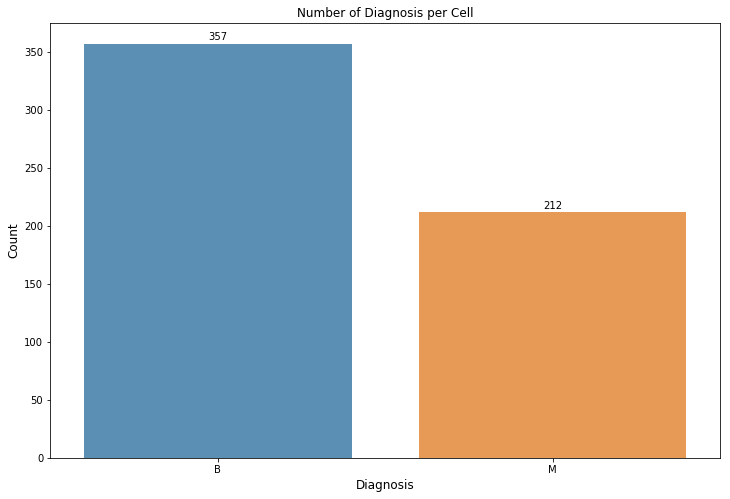

In [158]:
# Calculate and display the break down of observations by cell diagnosis
diagnosis = df['diagnosis'].value_counts()
values = diagnosis.values

plt.figure(figsize=(12,8))
ax= plt.subplot()
sns.barplot(diagnosis.index,diagnosis.values, alpha=0.8)
ax.set_xlabel('Diagnosis', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Number of Diagnosis per Cell')
ax.set_xticklabels(diagnosis.index)

rects = ax.patches

for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, val, ha='center', va='top')

The dataset consists of 357 benign cell observations and 212 malignent cell observations

## Predicitve variables

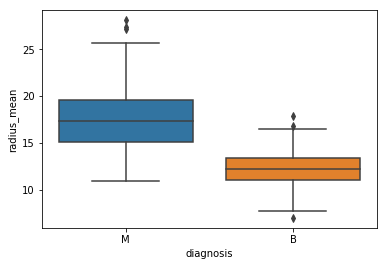

In [159]:
# Boxplot of the radius mean of benign and malignant tumors
sns.boxplot(x='diagnosis', y ='radius_mean', data=df)

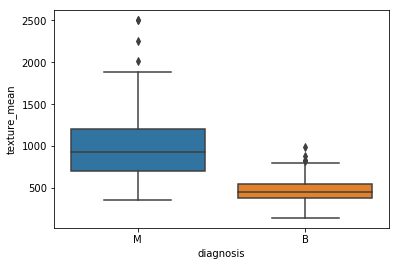

In [160]:
# Boxplot of the texture mean of  benign and malignant tumors
sns.boxplot(x='diagnosis', y ='texture_mean', data=df)

In both boxplots it is clearly evidenty that malignant tumors have both a larger radius mean and texture mean than benign tumors. Only outlier benign tumors have means in both categories as large as malignant.

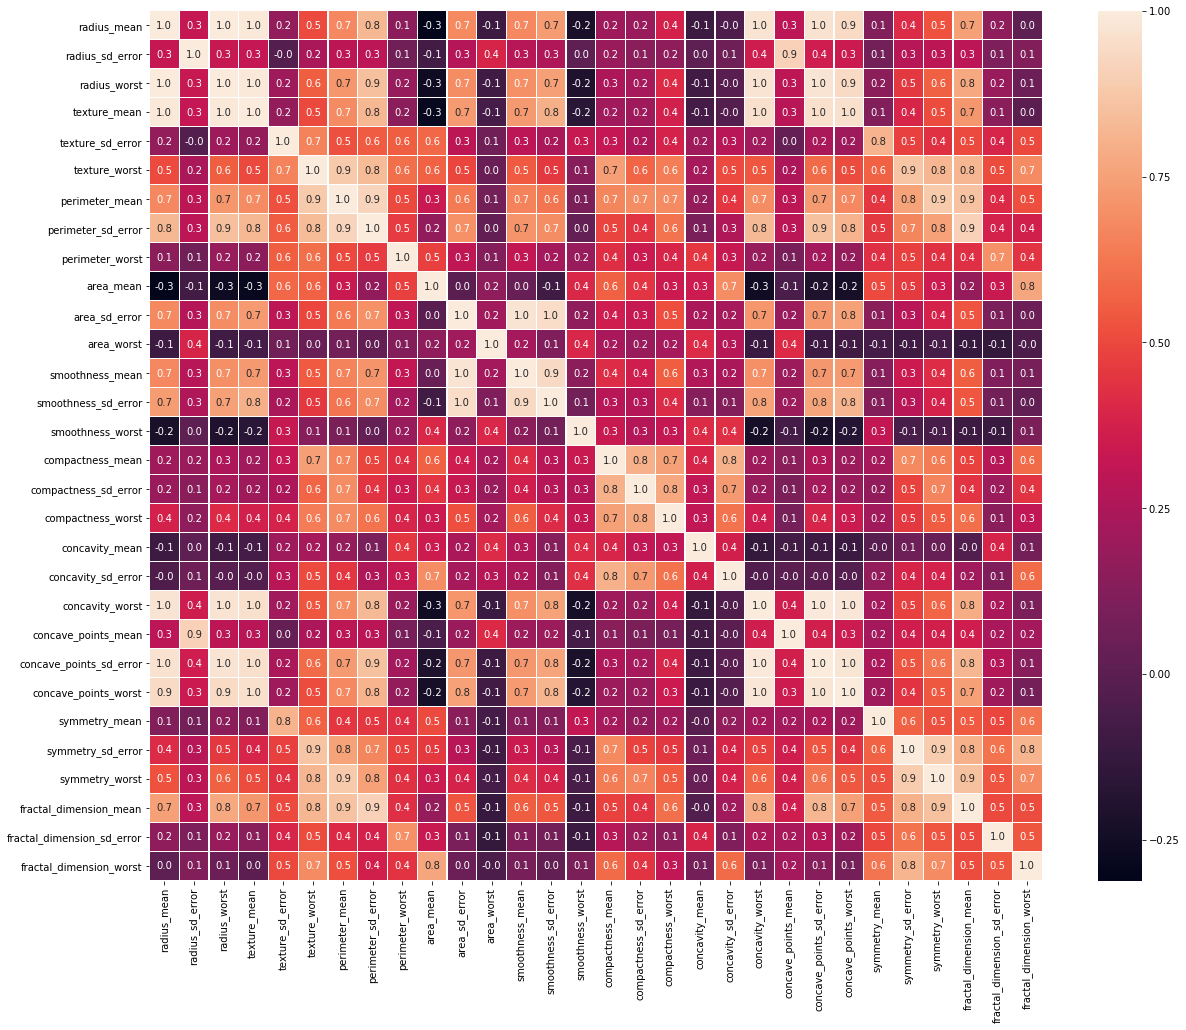

In [161]:
# Create a Correlation map to show relationship between characteristics within dataset and identify multicolinearity
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(df.corr(), annot =True, linewidths=.3, fmt='.1f', ax=ax)

In [162]:
# Pandas describe command gives useful information about the numeric values of the observations within the dataset
df.describe()

,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,area_mean,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [163]:
print('Baseline Accuracy for the Classfication task is {}%'.format(diagnosis['B']/df['diagnosis'].count() *100))

Baseline Accuracy for the Classfication task is 62.741652021089635%


# Random Forest Classifier

In [164]:
y=df['diagnosis']
df.drop('diagnosis', axis=1, inplace=True)
X=df

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [166]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [167]:
params=  {
    'criterion': ['entropy', 'gini'],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[2,3,4],
    }

In [168]:
gs = GridSearchCV(rfc, param_grid=params, cv = 3,  n_jobs=3)
gs.fit(X,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'criterion': ['entropy', 'gini'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [169]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2'}

In [170]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [171]:
rfc = RandomForestClassifier(max_depth=4, max_features='auto')
rfc.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [172]:
for idx, col in enumerate(df.columns):
    print(col, rfc.feature_importances_[idx])

radius_mean 0.0923974360222
radius_sd_error 0.0405072242365
radius_worst 0.000764312142429
texture_mean 0.0736472449511
texture_sd_error 0.00355285674194
texture_worst 0.00687050578982
perimeter_mean 0.0823919480775
perimeter_sd_error 0.0836689339225
perimeter_worst 0.0
area_mean 0.00212492254728
area_sd_error 0.00867243602966
area_worst 0.000564745870465
smoothness_mean 0.00424634345122
smoothness_sd_error 0.0609615710099
smoothness_worst 0.000764312142429
compactness_mean 0.0021229690594
compactness_sd_error 0.00111764729929
compactness_worst 0.0015059664398
concavity_mean 0.00532465494987
concavity_sd_error 0.00333941114574
concavity_worst 0.0457695069988
concave_points_mean 0.0108095839003
concave_points_sd_error 0.133752275317
concave_points_worst 0.0319656471851
symmetry_mean 0.00639308289162
symmetry_sd_error 0.00149350437313
symmetry_worst 0.00208093190183
fractal_dimension_mean 0.274786569642
fractal_dimension_sd_error 0.0172064644864
fractal_dimension_worst 0.00119699147473


The most important features in classifying tumors as malignant or benign according to the random forest are fractal_dimensional_mean, radius_mean, and concave_points_worst.

Random Forest will overfit, so use cross validation to prevent overfiting

In [173]:
cv = cross_val_score(rfc, X_test, yhat, cv=3, scoring='accuracy')
np.mean(cv)

0.61988304093567248

In [174]:
cv = cross_val_score(rfc, X_test, yhat, cv=3, scoring='precision')
np.mean(cv)

0.44285714285714289

# Logistic Regression w/ Grid Search

In [175]:
# Create predictor and target variables. Label encode target variable for model.
lb = LabelEncoder()
y = lb.fit_transform(y)

In [176]:
# Standard Scale predictors so all values are on same numeric scale 
ss = StandardScaler()
X = ss.fit_transform(X)

In [177]:
# Instantiate a logistic regression
logreg = LogisticRegression()

In [178]:
# Create a parameters dictionary for grid search
params = {
    'penalty': ['l1','l2'],
    'C': [1,2,3]
}

In [179]:
gs = GridSearchCV(logreg, param_grid=params, cv = 3,  n_jobs=3)
gs.fit(X,y)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [180]:
gs.best_params_

{'C': 1, 'penalty': 'l2'}

In [181]:
gs.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Grid Search Cross Validation identifies the best parameters to classify our tumor cells with a Logistic Regression as a penalty of l2 and a C value of 1

In [182]:
# Run Logistic Regression wuiht best parameters from grid search
logreg = LogisticRegression(penalty='l2')
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [183]:
print(logreg.coef_)

[[-1.66132259 -0.11021075  0.06474187 -0.00180081  0.12389158  0.29802656
   0.5216365   0.26345119  0.22724848  0.0128468  -0.06040881 -0.89195015
  -0.18508463  0.10144411  0.01293027 -0.02767909  0.02992611  0.03082623
   0.02232426 -0.01274817 -1.45162962  0.29101809  0.12011011  0.02612847
   0.22636601  0.92462452  1.39686653  0.54115573  0.53398559  0.07379184]]


In [184]:
for idx,col in enumerate(df.columns):
    for val in logreg.coef_:
        print(col, val[idx])

radius_mean -1.66132258536
radius_sd_error -0.110210754305
radius_worst 0.0647418673941
texture_mean -0.00180081430576
texture_sd_error 0.123891584951
texture_worst 0.29802655895
perimeter_mean 0.52163649816
perimeter_sd_error 0.263451189802
perimeter_worst 0.227248476596
area_mean 0.0128468001256
area_sd_error -0.0604088087189
area_worst -0.891950149245
smoothness_mean -0.185084631077
smoothness_sd_error 0.101444110823
smoothness_worst 0.0129302652648
compactness_mean -0.0276790942578
compactness_sd_error 0.0299261089971
compactness_worst 0.030826233639
concavity_mean 0.0223242625396
concavity_sd_error -0.0127481706877
concavity_worst -1.45162962379
concave_points_mean 0.291018090473
concave_points_sd_error 0.120110110314
concave_points_worst 0.0261284681285
symmetry_mean 0.226366007277
symmetry_sd_error 0.924624520596
symmetry_worst 1.396866529
fractal_dimension_mean 0.541155725886
fractal_dimension_sd_error 0.533985591958
fractal_dimension_worst 0.0737918374594


The most important features in classifying tumors as malignant or benign according to the logistic regression are fractal_dimensional_mean, radius_mean, and concave_points_worst.

In [185]:
yhat = logreg.predict(X_test)

In [188]:
confusion_matrix(y_test, yhat)

array([[111,   2],
       [  3,  55]], dtype=int64)

# Results and Limitations

The logistic regression model predicts with an accuracy of 98% and a precision of 96% on the test data. Whereas the Random Forest has an accuracy of 92% and a precision of 90%. The confusion matrix shows 109 True negatives, it correctly classified a tumor as not malignent. 3 False negatives, it misclassified a tumor as not malignent. 2 false positives, misclassified a tumor as malignent. 57 true positives, properly classified a tumor as malignent.

The only limitation of this model was the limited amount of observations that the dataset contained. OIbtaining more data would further improve the model's precision and accuracy.

Both of these models classify the datset, but do it in slighly different ways. The logisitic regression uses a probability function to calculate the likelihood that an observation belongs to one class or another. The Random forest, on the other hand is identifies the most distinguishable characteristic within the leaf and splits the dataset based on that characteristic. Logistic Regression has the advantage of being easily undertood, fast, and efficient. The advantages of a Random Forest is its flexibile data structure requirements and its extremely accurate 

According to the Dataset the most identifiable variables for identifying malignent tumors are fractal_dimensional_mean, radius_mean, and concave_points_worst.

# Part 2:Review and Debug

## Sample 1

No description about models purpose

Incorrectly importing the Linear Regression package. Should read

from sklearn.linear_model import LinearRegression

Do not need train test split package. 

Undefined variable data, should be d

Use y, X for target and predictor variables not x1,x2

Linear Regression normally use Root Mean Squared Error as it better accounts for  large outliers in the data

Only 1 score so no need for mean value


## Sample 2

No description about models purpose

Linear Regression normally use Root Mean Squared Error as it better accounts for  large outliers in the data
